In [1]:
import torch
from torch.utils.data import Dataset, DataLoader
import torch.optim as optim
import pandas as pd
import numpy as np
import os
import torch.nn as nn
import torch.nn.functional as F
import sys
import warnings
warnings.filterwarnings("ignore")
import random
import matplotlib.pyplot as plt
sys.path.insert(1, '/home/wangc90/Data_integration/MOCSS/mocss/code/')
import evaluation
from Data_prep import DataSet_Prep, DataSet_construction
from tsn_visulization import tsn_data, tsn_plot
random.seed(2023)
torch.manual_seed(2023)

In [2]:
### variationalAE with concatenated inputs (X-VAE)
### In order to train the variational autoencoder, we only 
### need to add the auxillary loss in our training algorithm

class X_AE_Encoder(nn.Module):
    
    def __init__(self):
        
        ### input dimension for omic 1, omic 2 and omic 3
        self.s1_input_dim = 20531
        self.s2_input_dim = 1046
        
        
        ### layer 1 output dimension for omic 1, omic 2, omic 3 and omic 123
        self.l1_s1_out_dim = 128
        self.l1_s2_out_dim = 1024
        
        self.l2_s12_out_dim = 128
        self.l3_s12_out_dim = 1024
        
        self.common_embed_dim = 256
        
        
        super(X_AE_Encoder, self).__init__()
        
        ### encoder structure:
        
        ### first layer
        self.l1_s1 = nn.Linear(self.s1_input_dim, self.l1_s1_out_dim)
        self.l1_s1_bn = nn.BatchNorm1d(self.l1_s1_out_dim)
        l1_s1_drop_rate = 0
        self.drop_l1_s1 = nn.Dropout(p=l1_s1_drop_rate)
        
        
        self.l1_s2 = nn.Linear(self.s2_input_dim, self.l1_s2_out_dim)
        self.l1_s2_bn = nn.BatchNorm1d(self.l1_s2_out_dim)
        l1_s2_drop_rate = 0
        self.drop_l1_s2 = nn.Dropout(p=l1_s2_drop_rate)
        
        
        self.l2_s12 = nn.Linear(self.l1_s1_out_dim + self.l1_s2_out_dim,
                                 self.l2_s12_out_dim)
        self.l2_s12_bn = nn.BatchNorm1d(self.l2_s12_out_dim)
        l2_s12_drop_rate = 0.2
        self.drop_l2_s12 = nn.Dropout(p=l2_s12_drop_rate)
        
        
        self.l3_s12 = nn.Linear(self.l2_s12_out_dim,  self.l3_s12_out_dim)
        self.l3_s12_bn = nn.BatchNorm1d(self.l3_s12_out_dim)
        l3_s12_drop_rate = 0.4
        self.drop_l3_s12 = nn.Dropout(p=l3_s12_drop_rate)
        
        
        ## embedding layer
        self.embed_s12 = nn.Linear(self.l3_s12_out_dim, self.common_embed_dim)
        self.embed_s12_bn = nn.BatchNorm1d(self.common_embed_dim)
        embed_s12_drop_rate = 0
        self.drop_embed_s12 = nn.Dropout(p=embed_s12_drop_rate)
        
        

    def forward(self, s1, s2, labels=None):
        
        s1_ = self.drop_l1_s1(self.l1_s1_bn(F.relu(self.l1_s1(s1))))
        s2_ = self.drop_l1_s2(self.l1_s2_bn(F.relu(self.l1_s2(s2))))
        
        s12_ = torch.cat((s1_, s2_), dim=1)
        
        s12_ = self.drop_l2_s12(self.l2_s12_bn(F.relu(self.l2_s12(s12_))))
        s12_ = self.drop_l3_s12(self.l3_s12_bn(F.relu(self.l3_s12(s12_))))
        
        z12 = self.drop_embed_s12(self.embed_s12_bn(F.relu(self.embed_s12(s12_))))
        
        return z12, labels
        

class X_AE_Decoder(nn.Module):
    
    def __init__(self):
        
        
        
        
        self.s1_input_dim = X_AE_Encoder().s1_input_dim
        self.s2_input_dim = X_AE_Encoder().s2_input_dim
        self.common_embed_dim = X_AE_Encoder().common_embed_dim
        
        
        self._embed_s1_out_dim = 64
        self._l3_s1_out_dim = 128
        self._l2_s1_out_dim = 1024
        self._l1_s1_out_dim = self.s1_input_dim
        
        
        self._embed_s2_out_dim = 256
        self._l3_s2_out_dim = 1024
        self._l2_s2_out_dim = 32
        self._l1_s2_out_dim = self.s2_input_dim
        
        
        super(X_AE_Decoder, self).__init__()
        
        
        self._embed_s1 = nn.Linear(self.common_embed_dim, self._embed_s1_out_dim)
        self._embed_s1_bn = nn.BatchNorm1d(self._embed_s1_out_dim)
        _embed_s1_drop_rate = 0.2
        self._drop_embed_s1 = nn.Dropout(p=_embed_s1_drop_rate)
        
        
        self._l3_s1 = nn.Linear(self._embed_s1_out_dim, self._l3_s1_out_dim)
        self._l3_s1_bn = nn.BatchNorm1d(self._l3_s1_out_dim)
        _l3_s1_drop_rate = 0.6
        self._drop_l3_s1 = nn.Dropout(p=_l3_s1_drop_rate)
        
        
        self._l2_s1 = nn.Linear(self._l3_s1_out_dim, self._l2_s1_out_dim)
        self._l2_s1_bn = nn.BatchNorm1d(self._l2_s1_out_dim)
        _l2_s1_drop_rate = 0
        self._drop_l2_s1 = nn.Dropout(p=_l2_s1_drop_rate)
        
        
        self._l1_s1 = nn.Linear(self._l2_s1_out_dim, self._l1_s1_out_dim)
        self._l1_s1_bn = nn.BatchNorm1d(self._l1_s1_out_dim)
        _l1_s1_drop_rate = 0
        self._drop_l1_s1 = nn.Dropout(p=_l1_s1_drop_rate)
        
        
        #############################################################################

        self._embed_s2 = nn.Linear(self.common_embed_dim, self._embed_s2_out_dim)
        self._embed_s2_bn = nn.BatchNorm1d(self._embed_s2_out_dim)
        _embed_s2_drop_rate = 0.1
        self._drop_embed_s2 = nn.Dropout(p=_embed_s2_drop_rate)
        
        
        self._l3_s2 = nn.Linear(self._embed_s2_out_dim, self._l3_s2_out_dim)
        self._l3_s2_bn = nn.BatchNorm1d(self._l3_s2_out_dim)
        _l3_s2_drop_rate = 0.6
        self._drop_l3_s2 = nn.Dropout(p=_l3_s2_drop_rate)
        
        
        self._l2_s2 = nn.Linear(self._l3_s2_out_dim, self._l2_s2_out_dim)
        self._l2_s2_bn = nn.BatchNorm1d(self._l2_s2_out_dim)
        _l2_s2_drop_rate = 0.4
        self._drop_l2_s2 = nn.Dropout(p=_l2_s2_drop_rate)
        
        
        self._l1_s2 = nn.Linear(self._l2_s2_out_dim, self._l1_s2_out_dim)
        self._l1_s2_bn = nn.BatchNorm1d(self._l1_s2_out_dim)
        _l1_s2_drop_rate = 0.1
        self._drop_l1_s2 = nn.Dropout(p=_l1_s2_drop_rate)
        

    def forward(self, z12):
        
        s1_ = self._drop_embed_s1(self._embed_s1_bn(F.relu(self._embed_s1(z12))))
        s1_ = self._drop_l3_s1(self._l3_s1_bn(F.relu(self._l3_s1(s1_))))
        s1_ = self._drop_l2_s1(self._l2_s1_bn(F.relu(self._l2_s1(s1_))))
        s1_ = self._drop_l1_s1(self._l1_s1_bn(F.relu(self._l1_s1(s1_))))
        
        s1_out = torch.sigmoid(s1_)
        
        
        s2_ = self._drop_embed_s2(self._embed_s2_bn(F.relu(self._embed_s2(z12))))
        s2_ = self._drop_l3_s2(self._l3_s2_bn(F.relu(self._l3_s2(s2_))))
        s2_ = self._drop_l2_s2(self._l2_s2_bn(F.relu(self._l2_s2(s2_))))
        s2_ = self._drop_l1_s2(self._l1_s2_bn(F.relu(self._l1_s2(s2_))))
        
        s2_out = torch.sigmoid(s2_)
        
        
        return s1_out, s2_out
        
    
class X_AE(nn.Module):
    def __init__(self):
        
        super(X_AE, self).__init__()
        
        self.encoder = X_AE_Encoder()
        
        self.decoder = X_AE_Decoder()

    def forward(self, s1, s2, labels):
        ### encoder ouput for embeddings 
        z12, labels = self.encoder(s1, s2, labels)
        ### decoder output for reconstructed input
        s1_out, s2_out = self.decoder(z12)
        return z12, s1_out, s2_out, labels

In [3]:
X_AE()

X_AE(
  (encoder): X_AE_Encoder(
    (l1_s1): Linear(in_features=20531, out_features=128, bias=True)
    (l1_s1_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_l1_s1): Dropout(p=0, inplace=False)
    (l1_s2): Linear(in_features=1046, out_features=1024, bias=True)
    (l1_s2_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_l1_s2): Dropout(p=0, inplace=False)
    (l2_s12): Linear(in_features=1152, out_features=128, bias=True)
    (l2_s12_bn): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_l2_s12): Dropout(p=0.2, inplace=False)
    (l3_s12): Linear(in_features=128, out_features=1024, bias=True)
    (l3_s12_bn): BatchNorm1d(1024, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (drop_l3_s12): Dropout(p=0.4, inplace=False)
    (embed_s12): Linear(in_features=1024, out_features=256, bias=True)
    (embed_s12_bn): BatchNorm1d(256, eps=1

In [4]:
def CustomLoss(s1, s2, s1_out, s2_out,
                z12, labels, z1=None, z2=None):
    #         self.alpha = alpha

    ### subtract the mean 

#     s1_out = s1_out - s1_out.mean()
#     s2_out = s2_out - s2_out.mean()
    
    ### normalize the feature vector with length 1
    s1_out = F.normalize(s1_out, p=2, dim=1)
    s2_out = F.normalize(s2_out, p=2, dim=1)
    
    
#     s1 = s1 - s1.mean()
#     s2 = s2 - s2.mean()
    s1 = F.normalize(s1, p=2, dim=1)
    s2 = F.normalize(s2, p=2, dim=1)

    recon_loss = torch.linalg.matrix_norm(s1_out-s1) + torch.linalg.matrix_norm(s2_out-s2)

    return recon_loss

In [5]:
### assuming all the hyperparameters are optimized by Optuna and then retrain the model on the entire training set

def retraining(model, dataset, model_folder):
    
    train_recon_loss_ = []

    device = torch.device('cuda:1') if torch. cuda.is_available() else torch.device('cpu')
    
    batch_size = 256
    
    train_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4)
#     print(len(train_loader))
    
    model = model().to(device=device)
#     print(model)
    
    
    optimizer_name = 'Adam'
    lr = 0.009879554857102159
    l2_lambda = 7.987530040843315e-06
    optimizer = getattr(optim, optimizer_name)(model.parameters(), lr=lr, weight_decay=l2_lambda)
    
    epochs = 120 ### reduce the epochs from 150 to 100 to reduce the potential overfitting
    
    for epoch in range(epochs):
        #         print(f"I'am in the epoch {epoch}")
        model.train()
        # record the training loss
        total_recon_loss = 0.0
        total_train = 0.0

        ## deal with different number of features in different dataset with star* notation
        for view1_train_data, view2_train_data, train_labels in train_loader:
            ### this line is just for nn.CrossEntropy loss otherwise can be safely removed
            view1_train_data = view1_train_data.type(torch.float32).to(device)
            view2_train_data = view2_train_data.type(torch.float32).to(device)
            train_labels = train_labels.type(torch.LongTensor).to(device)

            z12, s1_out, s2_out, labels = \
            model(view1_train_data, view2_train_data, train_labels)
            
            train_size = z12.size()[0]
    
            recon_loss = CustomLoss(s1=view1_train_data,\
                                             s2=view2_train_data,\
                                             s1_out=s1_out,\
                                             s2_out=s2_out,\
                                             z12=z12,\
                                             labels=train_labels)
            loss = recon_loss

            # backward pass
            optimizer.zero_grad()  # empty the gradient from last round

            # calculate the gradient
            loss.backward()
            # update the parameters
            optimizer.step()
            
            total_train += train_size
            
            total_recon_loss += recon_loss.item()
    
        train_recon_loss_.append(total_recon_loss / total_train)
        
        if (epoch+1) % 10 == 0:
            print(f'finished retraining on epoch: {epoch}')
    # save the model at the end of 150 epochs
    model_path = f"{model_folder}/retrained_model_{epoch}.pt"
    
    torch.save(model, model_path)
    
    return train_recon_loss_


In [6]:
def X_retraining():
    ### where to save the 3-fold CV validation acc

    ### where to save the retrained model
    model_folder = '/home/wangc90/Data_integration/TCGA_model_outputs/model_retraining_outputs/X_AE_retraining'

    combined_exp_df = pd.read_csv('/home/wangc90/Data_integration/TCGA_data/TCGA_primary_tumor_data/combined_exp_df.csv', sep='\t')
    combined_miRNA_df = pd.read_csv('/home/wangc90/Data_integration/TCGA_data/TCGA_primary_tumor_data/combined_miRNA_df.csv', sep='\t')

    labels = pd.read_csv('/home/wangc90/Data_integration/TCGA_data/TCGA_primary_tumor_data/labels.csv', sep='\t')['0']

    dataset_prep = DataSet_Prep(data1=combined_exp_df, data2=combined_miRNA_df, label=labels, training_prop=0.8)

    train_key, test_key = dataset_prep.get_train_test_keys()

    feature1_tensors, feature2_tensors, label_tensors = dataset_prep.to_tensor(train_key)
    

    train_dataset = DataSet_construction(feature1_tensors, feature2_tensors, label_tensors)

    print(len(train_dataset))

    train_recon_loss_ = retraining(model=X_AE, dataset=train_dataset,model_folder=model_folder)
    
    return train_recon_loss_

In [7]:
train_recon_loss_ = X_retraining()

feature1 and feature2 are being scaled with MinMaxScaler
1494
finished retraining on epoch: 9
finished retraining on epoch: 19
finished retraining on epoch: 29
finished retraining on epoch: 39
finished retraining on epoch: 49
finished retraining on epoch: 59
finished retraining on epoch: 69
finished retraining on epoch: 79
finished retraining on epoch: 89
finished retraining on epoch: 99
finished retraining on epoch: 109
finished retraining on epoch: 119


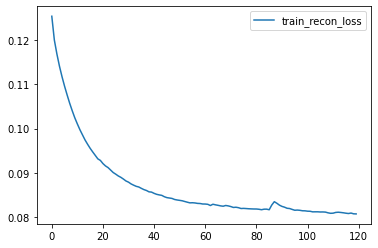

In [8]:
plt.figure()
plt.plot(train_recon_loss_, label='train_recon_loss')
plt.legend()
plt.show()